In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
!pip install tpot
from tpot import TPOTClassifier
!pip install scikit-optimize
from skopt import BayesSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11937 sha256=729374cff86a78a7edfd9d58ede6587995511ac796fe7357f3f7cbd97cd7754a
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.2 MB/s eta 0:00:00


In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [ ]:
import zipfile
import os

def unzip_file(zip_file, extract_folder):
    """
    Verilen zip dosyasını belirtilen klasöre çıkarır.

    Parametreler:
    - zip_file (str): Çıkarılacak zip dosyasının adı.
    - extract_folder (str): Çıkarılacak klasörün adı.
    """
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

def from_kaggle_import_df(competition_name):
    """
    Kaggle veri setini indirir ve çıkarır.

    Parametreler:
    - competition_name (str): Kaggle yarışmasının adı.
    """
    !pip install -q kaggle
    from google.colab import files
    files.upload()

    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets list
    !kaggle competitions download -c $competition_name

    zip_file = f"{competition_name}.zip"
    extract_folder = "train"

    unzip_file(zip_file, extract_folder)




In [ ]:
from_kaggle_import_df("playground-series-s4e1")

Saving kaggle.json to kaggle.json
ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                                     Apple Quality                                      170KB  2024-01-11 14:31:07           5282        128  1.0              
hummaamqaasim/jobs-in-data                                         Jobs and Salaries in Data Science                   76KB  2023-12-25 20:03:32          11786        222  1.0              
computingvictor/zillow-market-analysis-and-real-estate-sales-data  🏠 Airbnb Market Analysis & Real Estate Sales Data    3MB  2024-01-26 16:29:34            750         28  1.0              
mrsimple07/obesi

# Import Data and Preprocessing

In [ ]:
df_train = pd.read_csv("/content/train/train.csv", index_col="id")
df_test = pd.read_csv("/content/train/test.csv", index_col="id")
submis = pd.read_csv("/content/train/sample_submission.csv")

In [ ]:
df_train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.000,3,0.000,2,1.000,0.000,181449.970,0
1,15749177,Okwudiliolisa,627,France,Male,33.000,1,0.000,2,1.000,1.000,49503.500,0
2,15694510,Hsueh,678,France,Male,40.000,10,0.000,2,1.000,0.000,184866.690,0
3,15741417,Kao,581,France,Male,34.000,2,148882.540,1,1.000,1.000,84560.880,0
4,15766172,Chiemenam,716,Spain,Male,33.000,5,0.000,2,1.000,1.000,15068.830,0


In [ ]:
df_test.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.000,2,0.000,2,0.000,1.000,160976.750
165035,15782418,Nott,683,France,Female,46.000,2,0.000,1,1.000,0.000,72549.270
165036,15807120,K?,656,France,Female,34.000,7,0.000,2,1.000,0.000,138882.090
165037,15808905,O'Donnell,681,France,Male,36.000,8,0.000,1,1.000,0.000,113931.570
165038,15607314,Higgins,752,Germany,Male,38.000,10,121263.620,1,1.000,0.000,139431.000


In [ ]:
submis.head(3)

,id,Exited
0,165034,0.500
1,165035,0.500
2,165036,0.500


In [ ]:
df_train = df_train.drop(columns=["CustomerId"])

<Axes: >

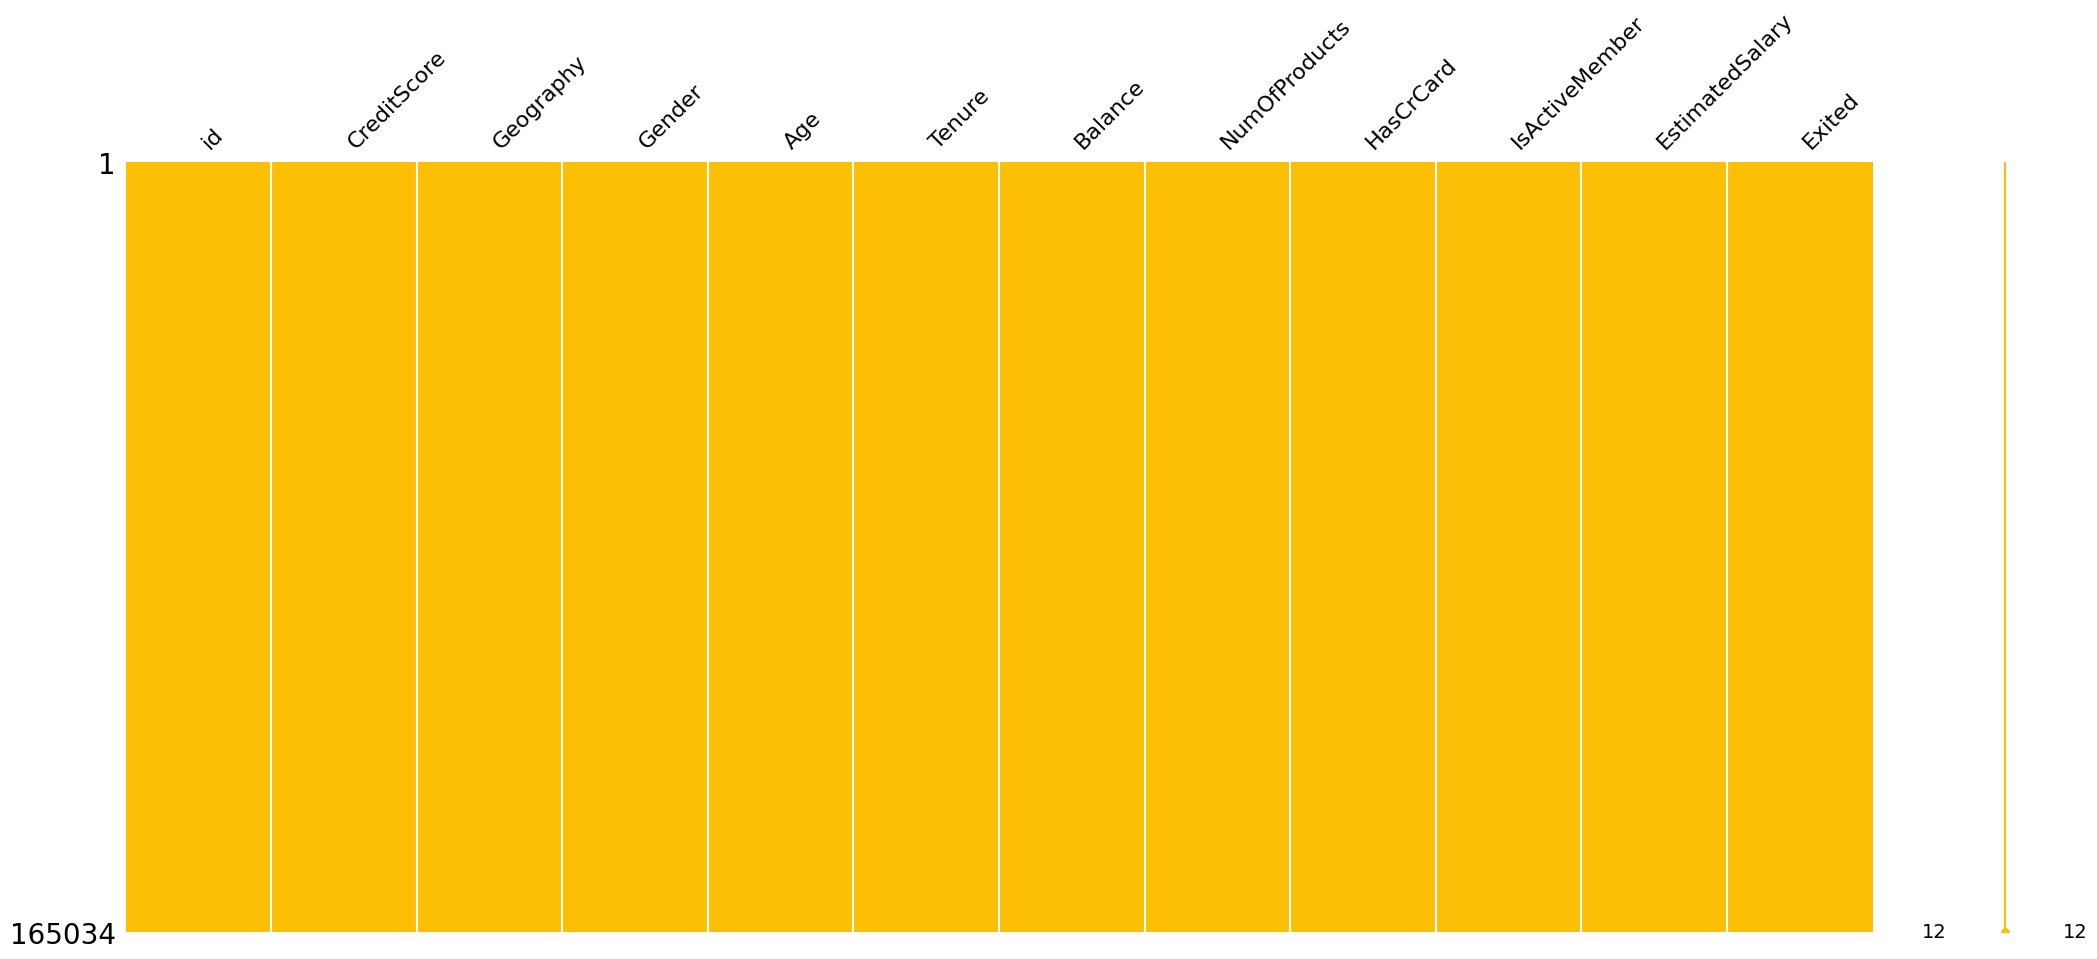

In [ ]:
msno.matrix(df_train,color=(0.99, 0.75, 0.023))

In [ ]:
!pip install sweetviz
import sweetviz as sv

report = sv.analyze(df_train)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 30.9 MB/s eta 0:00:00


                                             |          | [  0%]   00:00 -> (? left)


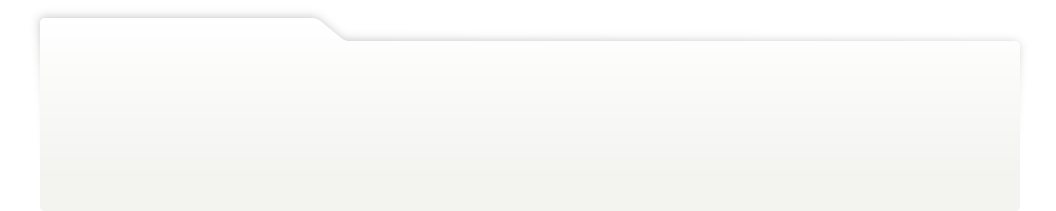
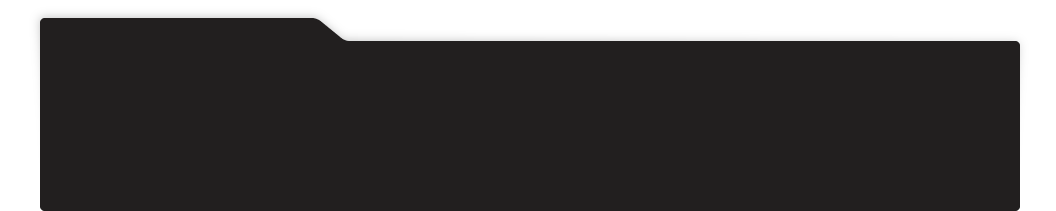
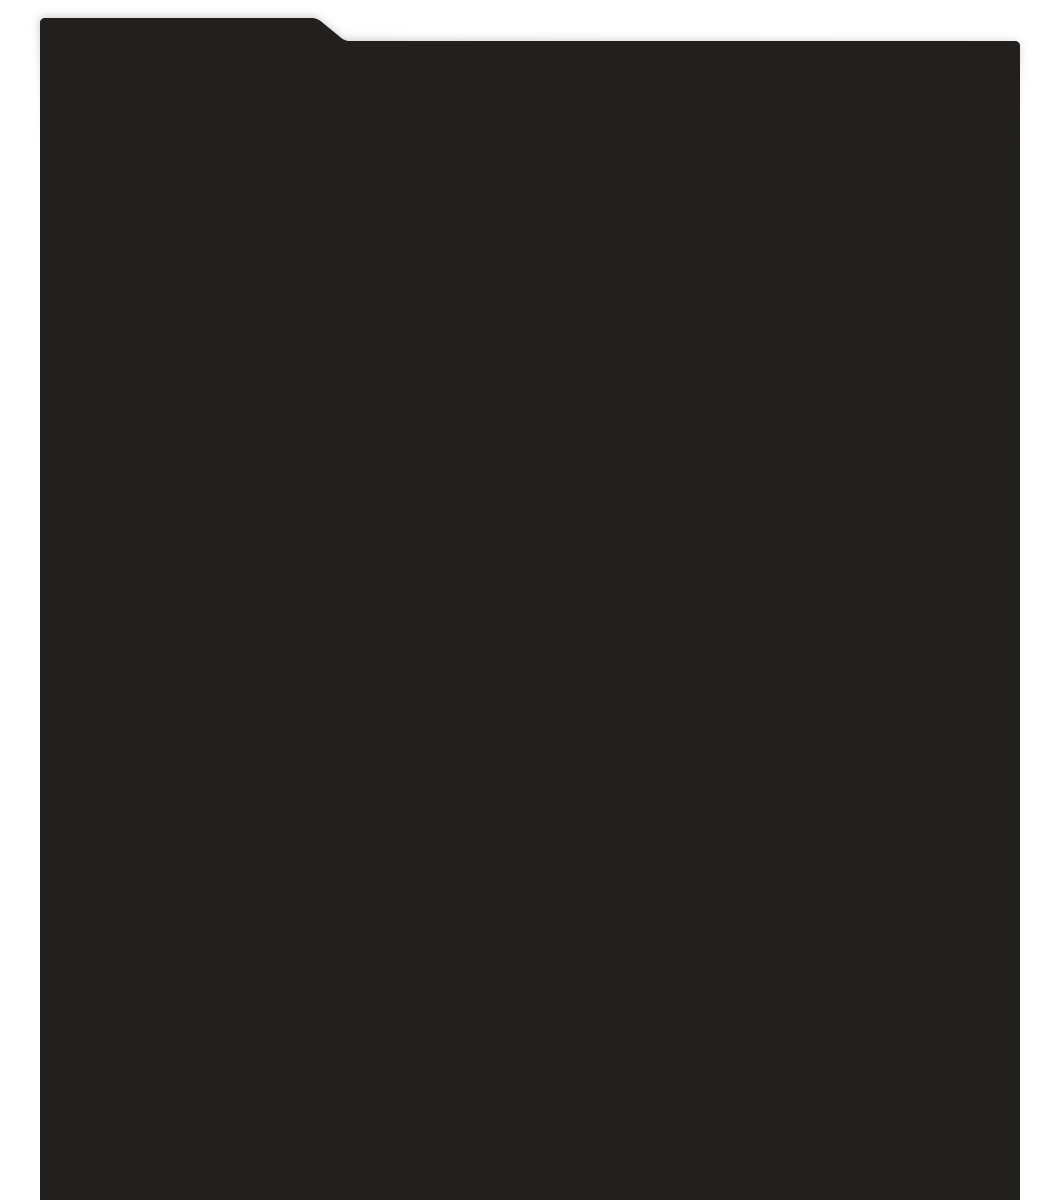
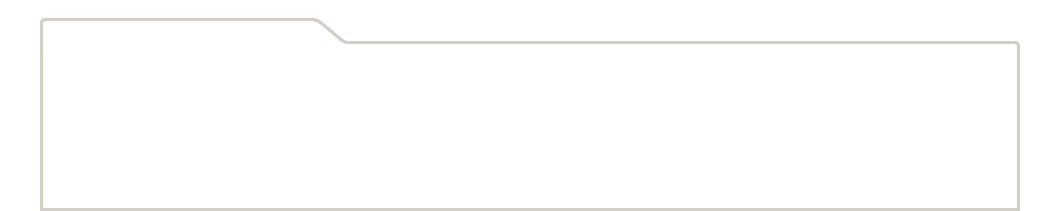
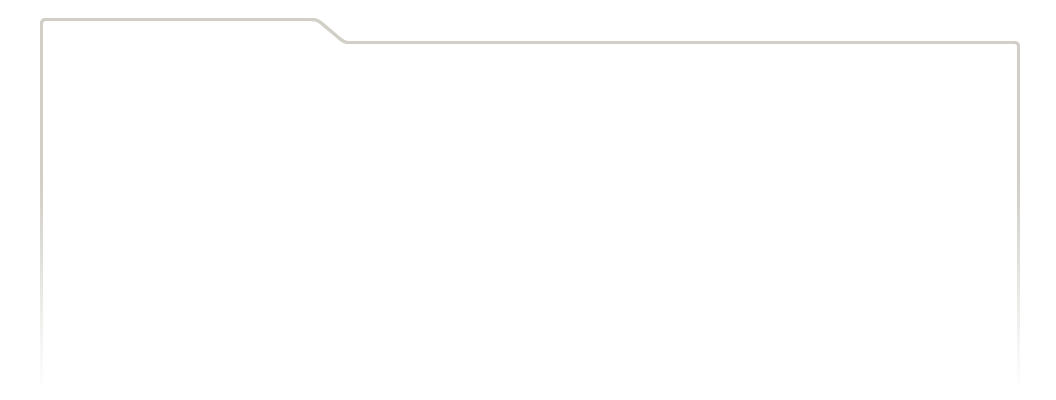
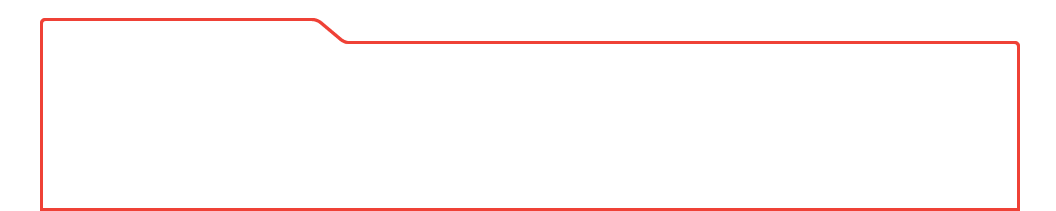
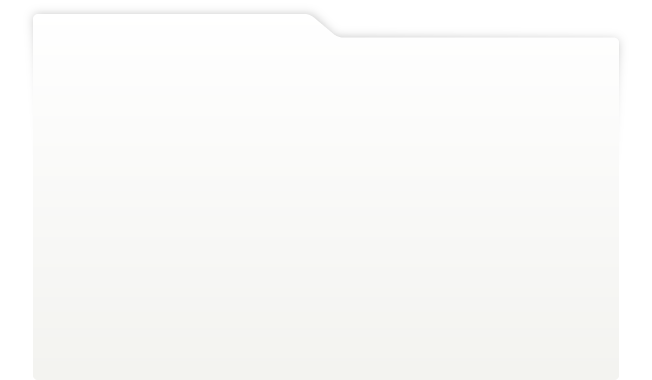
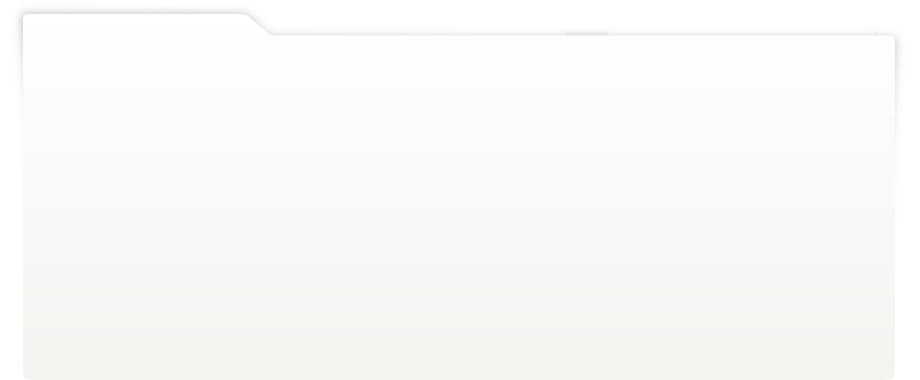
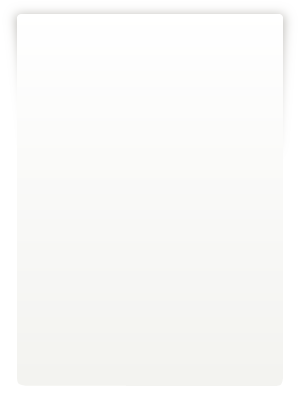
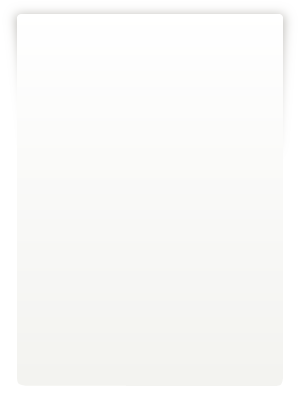
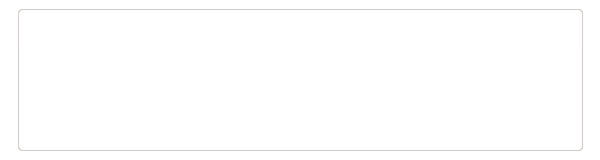
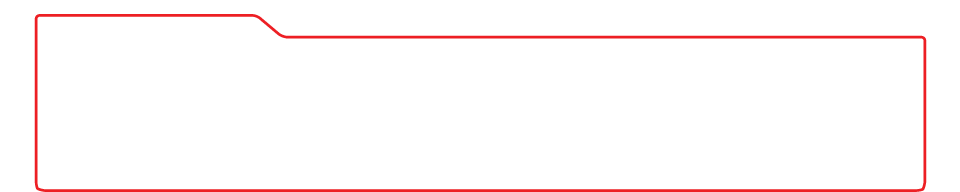
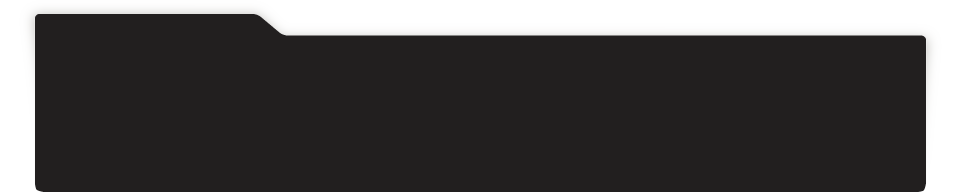
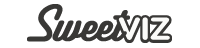
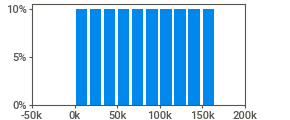
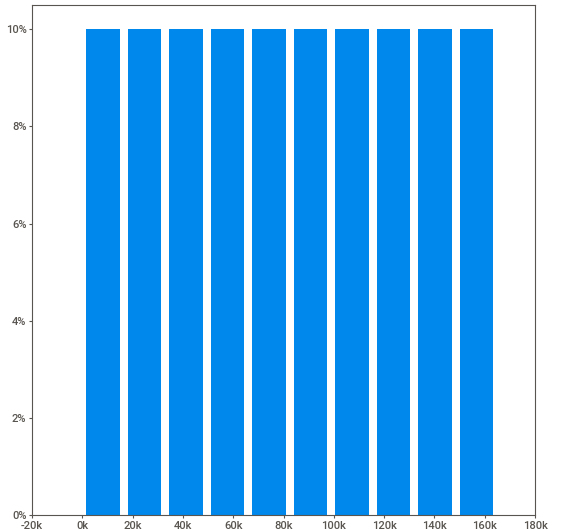
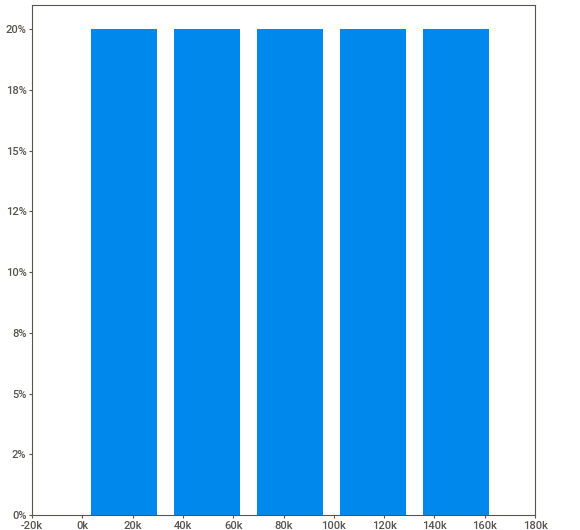
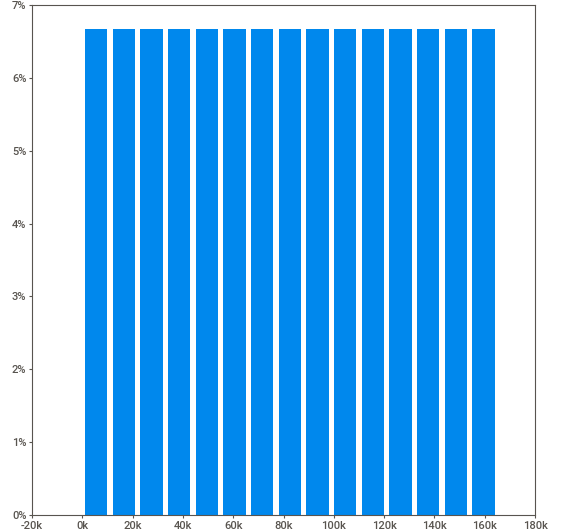
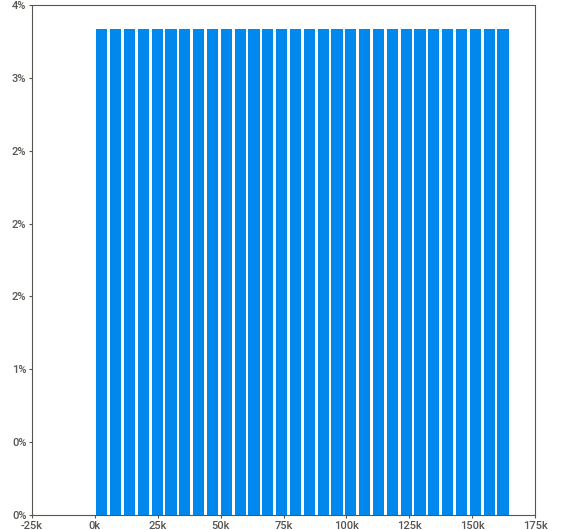
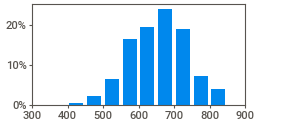
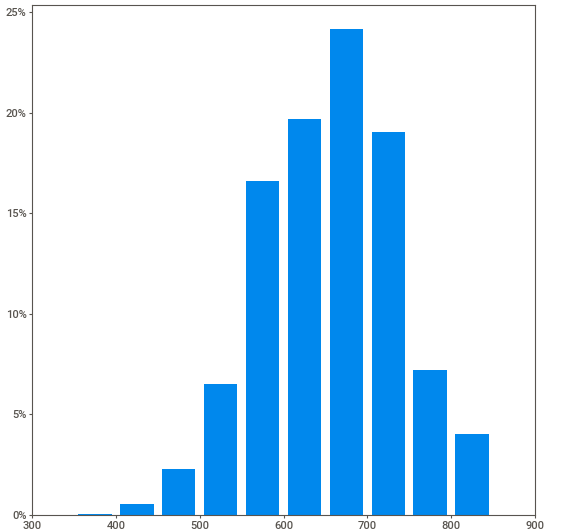
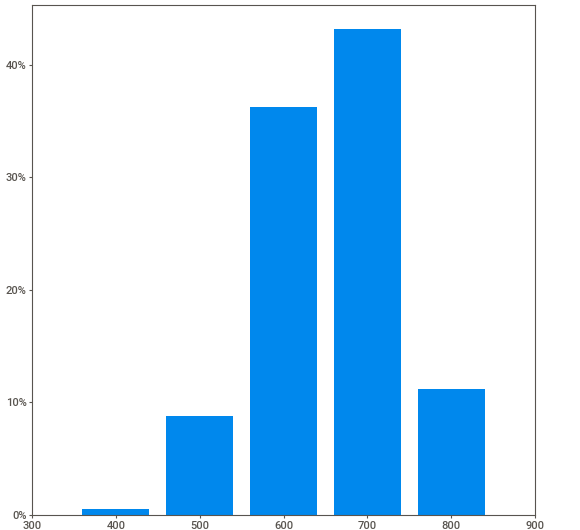
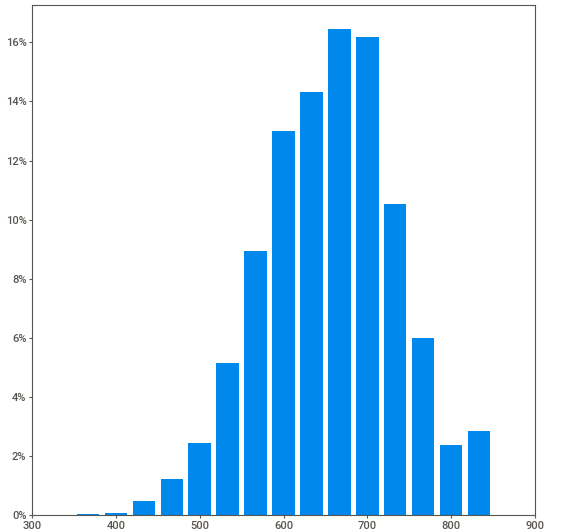
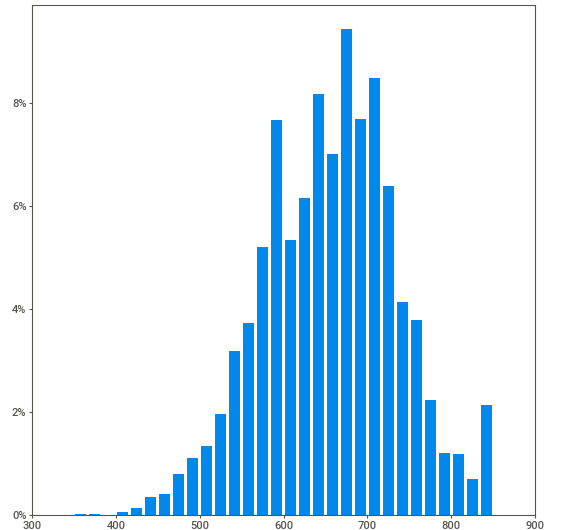
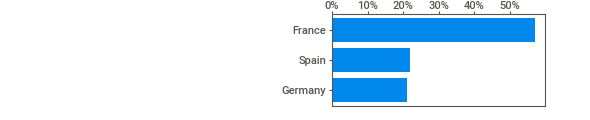
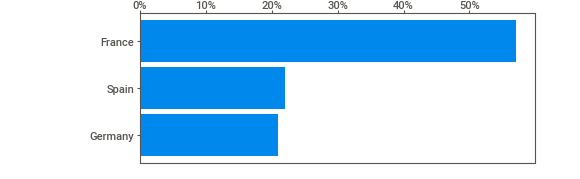
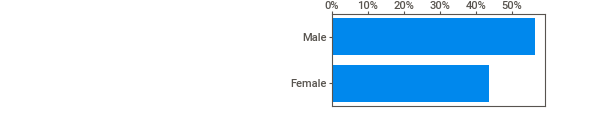
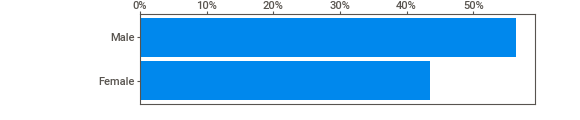
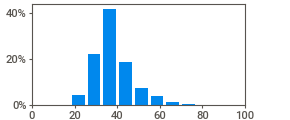
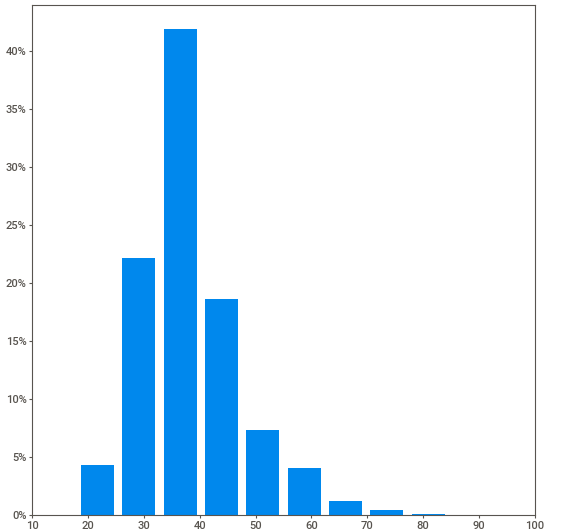
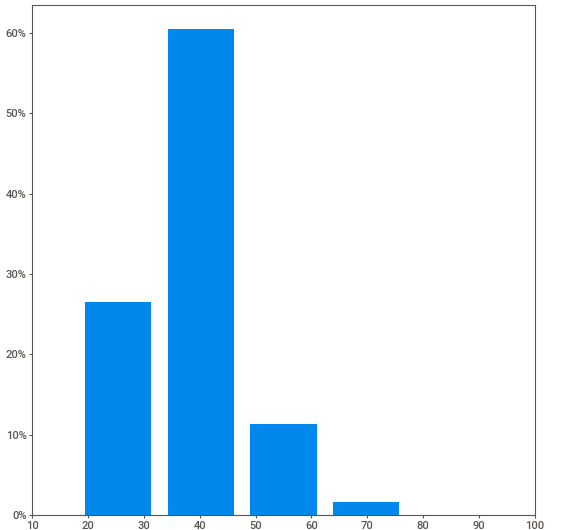
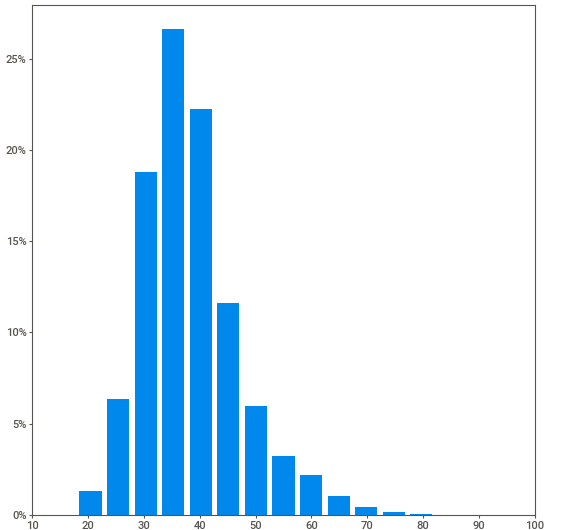
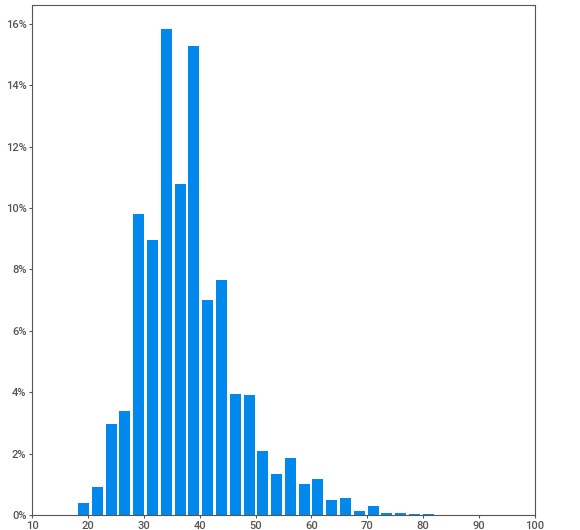
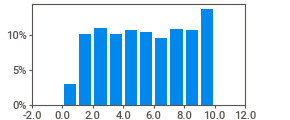
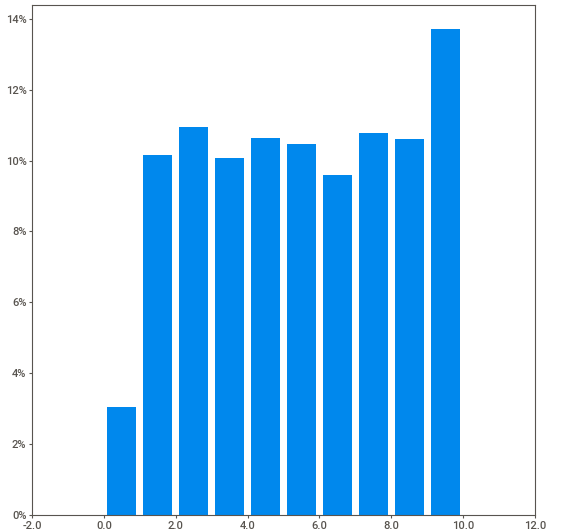
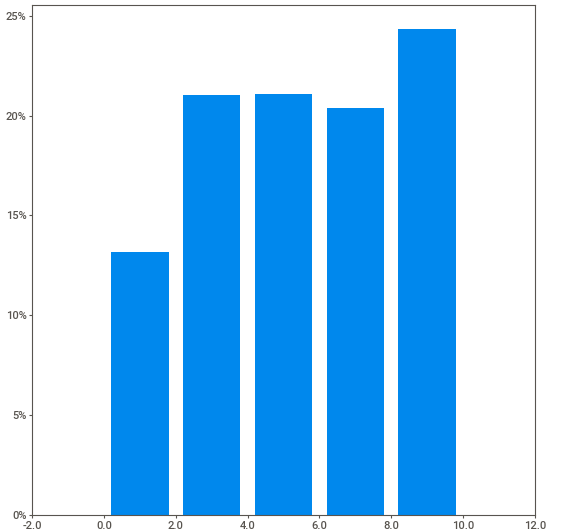
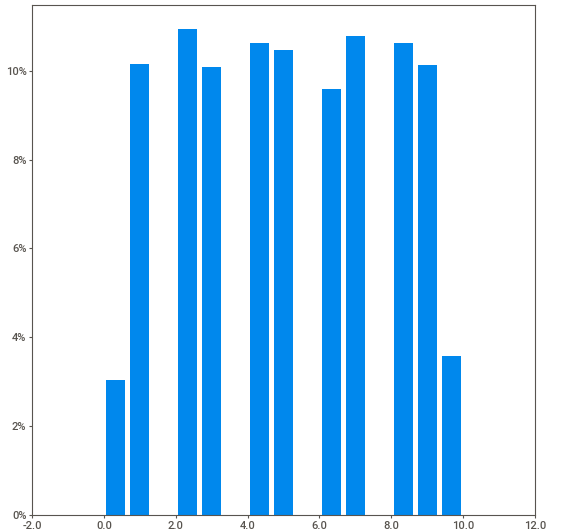
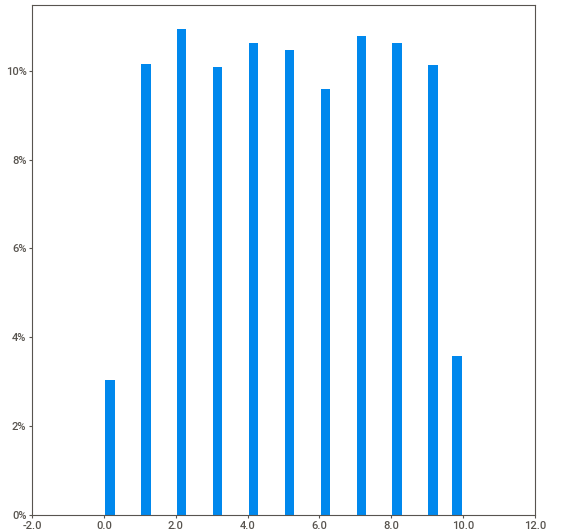
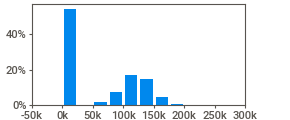
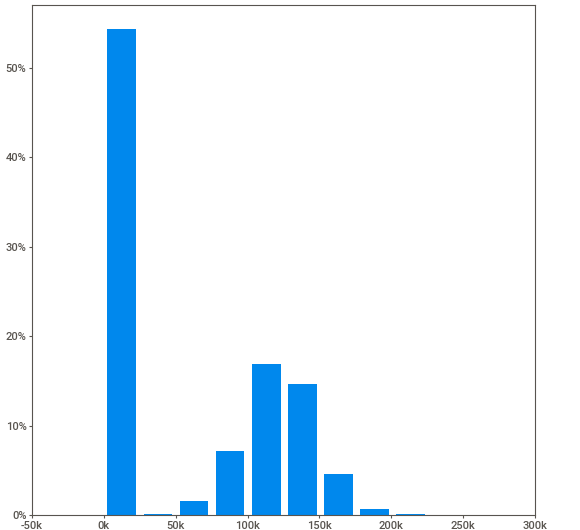
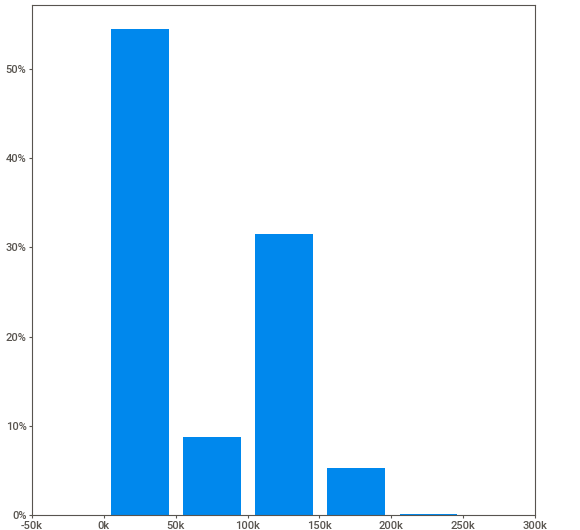
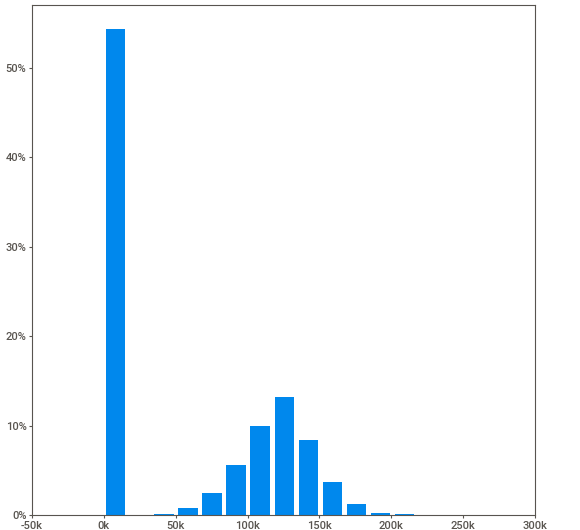
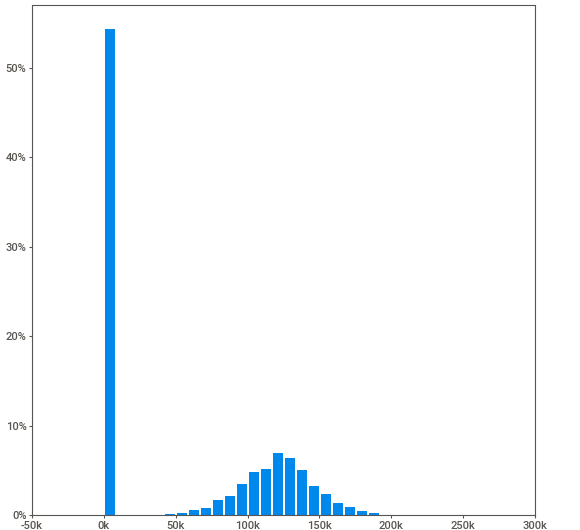
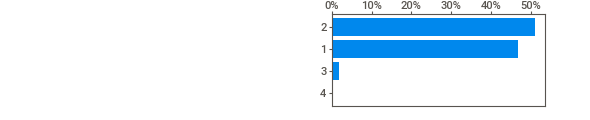
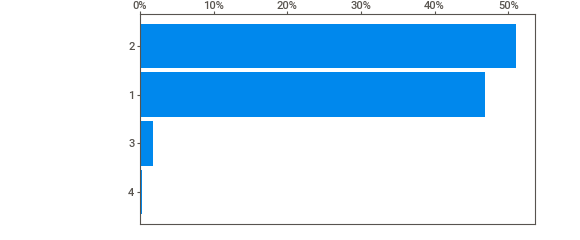
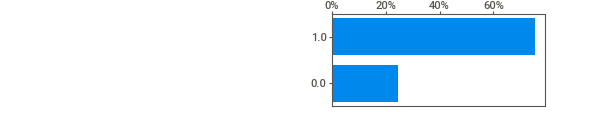
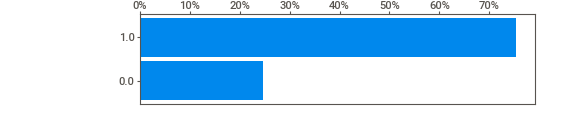
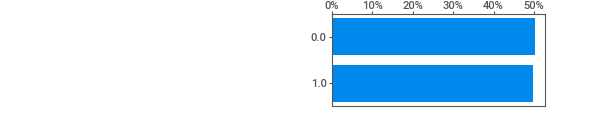
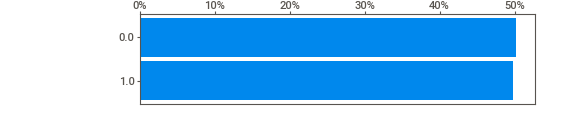
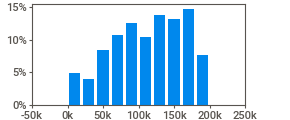
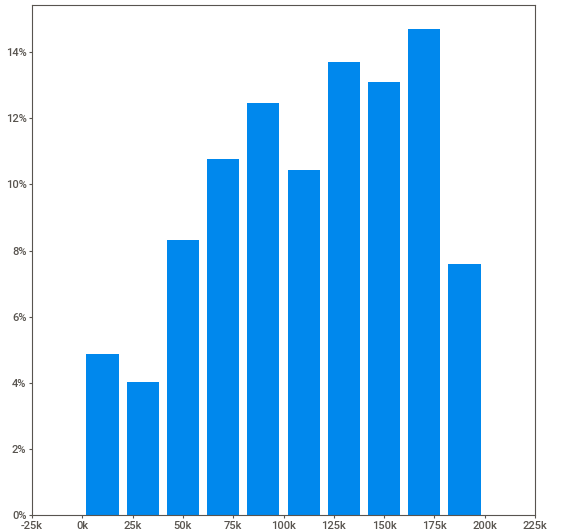
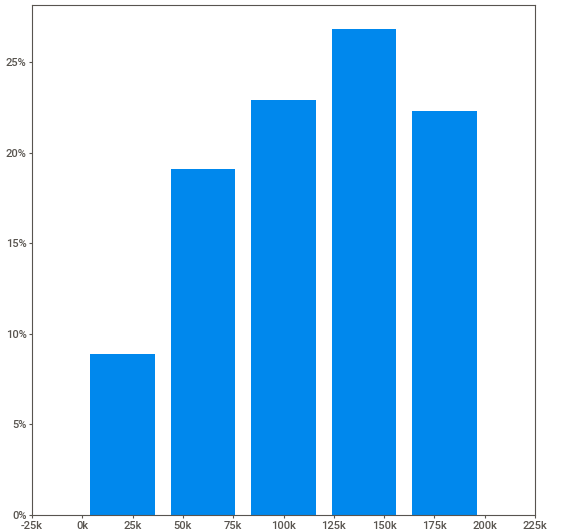
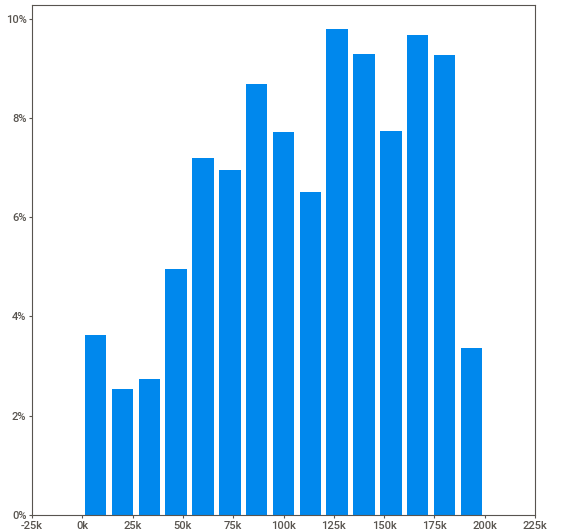
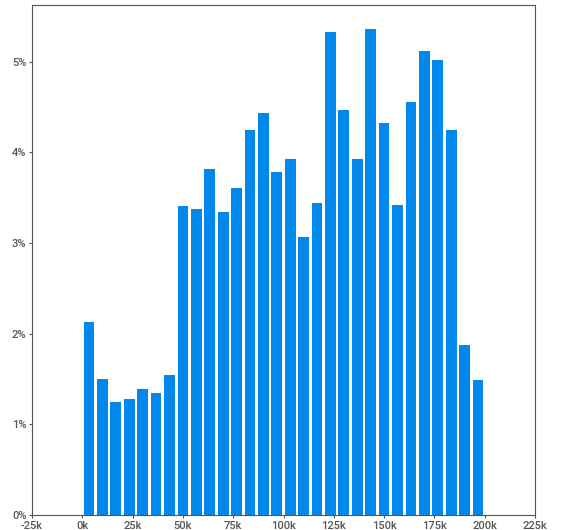
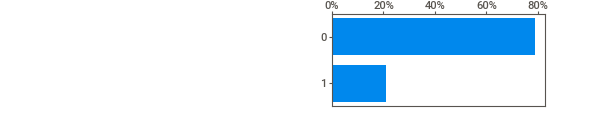
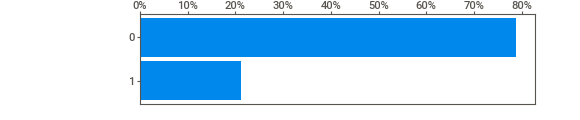
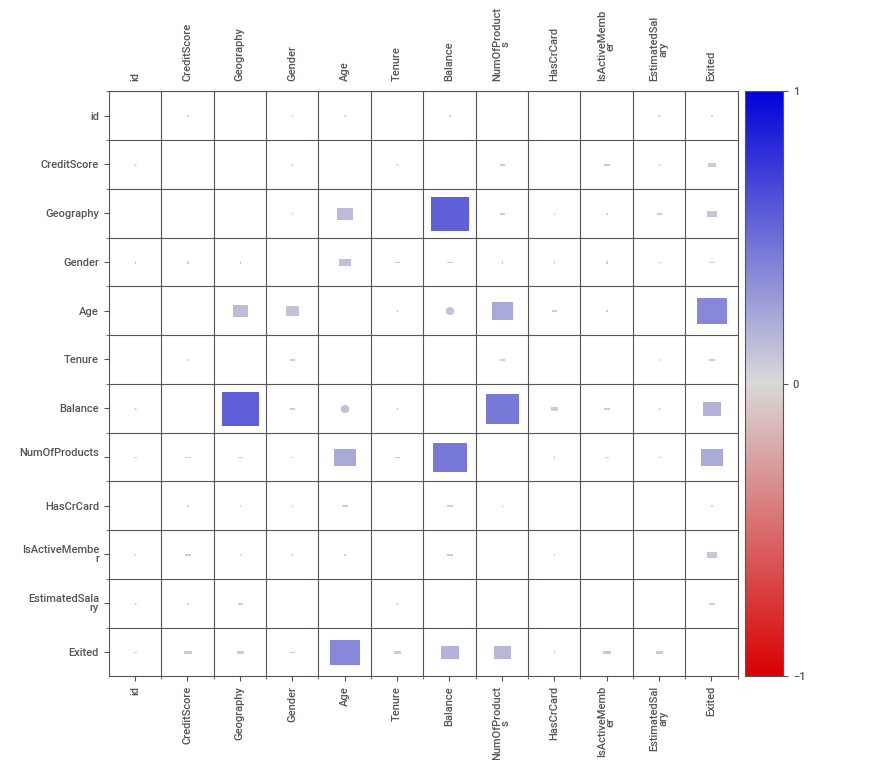
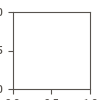

In [ ]:
report.show_notebook(w="70%", h="full")

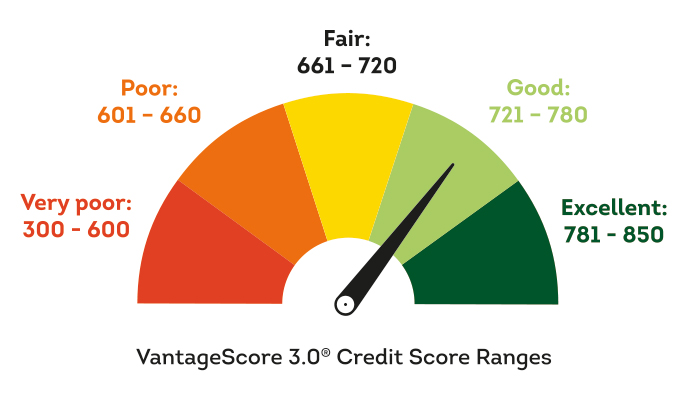

In [ ]:
df_train.sort_values(by='EstimatedSalary', ).head(3)

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
89788,89788,635,Germany,Female,32.000,9,128760.320,1,1.000,1.000,11.580,0
122294,122294,635,Spain,Male,45.000,5,122917.710,1,1.000,0.000,11.580,1
112272,112272,675,France,Male,38.000,9,125920.980,1,0.000,1.000,11.580,0


In [ ]:
df_train.sort_values(by='EstimatedSalary', ascending=False ).head(3)

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
115773,115773,681,Spain,Female,42.000,4,0.000,2,0.000,0.000,199992.480,0
84881,84881,479,Germany,Male,36.000,8,99183.900,1,0.000,0.000,199992.480,1
136835,136835,678,France,Female,42.000,1,0.000,2,0.000,1.000,199992.480,0


In [ ]:
bins = [300, 600, 660, 720, 780, 851]
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']

df_train['CreditScore_Col'] = pd.cut(df_train['CreditScore'], bins=bins, labels=labels, right=False)

ordinal_encoder = OrdinalEncoder(categories=[['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']])
df_train['CreditScore_Col_Ord'] = ordinal_encoder.fit_transform(df_train[['CreditScore_Col']])

le=LabelEncoder()
df_train["Geography_Encoded"] = le.fit_transform(df_train["Geography"])
# France : 0 , Germany = 1, Spain : 2

df_train["Gender_Encoded"] = le.fit_transform(df_train["Gender"])

# Female : 0, Male : 1

df_train["Gender_Encoded"] = le.fit_transform(df_train["Gender"])


# Female : 0, Male : 1


df_train["Surname_Encoded"] = le.fit_transform(df_train["Surname"])



In [ ]:
df_train.tail(3)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Col,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded
id,,,,,,,,,,,,,,,,,
165031,Hsia,565,France,Male,31.000,5,0.000,1,1.000,1.000,127429.560,0,Very Poor,0.000,0,1,1172
165032,Hsiung,554,Spain,Female,30.000,7,161533.000,1,0.000,1.000,71173.030,0,Very Poor,0.000,2,0,1176
165033,Ulyanov,850,France,Male,31.000,1,0.000,1,1.000,0.000,61581.790,1,Excellent,4.000,0,1,2564


In [ ]:
df_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Col,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded
id,,,,,,,,,,,,,,
0,668,33.000,3,0.000,2,1.000,0.000,181449.970,0,Fair,2.000,0,1,1924
1,627,33.000,1,0.000,2,1.000,1.000,49503.500,0,Poor,1.000,0,1,1925
2,678,40.000,10,0.000,2,1.000,0.000,184866.690,0,Fair,2.000,0,1,1178


In [ ]:
print(df_train["CreditScore_Col_Ord"].value_counts(), '\n', df_train["CreditScore_Col"].value_counts())



2.000    48607
0.000    42840
1.000    39842
3.000    24756
4.000     8989
Name: CreditScore_Col_Ord, dtype: int64 
 Fair         48607
Very Poor    42840
Poor         39842
Good         24756
Excellent     8989
Name: CreditScore_Col, dtype: int64


In [ ]:

df_train.drop(["Gender","Geography", "Surname", "CreditScore_Col"], axis=1, inplace=True)
df_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded
id,,,,,,,,,,,,,
0,668,33.000,3,0.000,2,1.000,0.000,181449.970,0,2.000,0,1,1924
1,627,33.000,1,0.000,2,1.000,1.000,49503.500,0,1.000,0,1,1925
2,678,40.000,10,0.000,2,1.000,0.000,184866.690,0,2.000,0,1,1178


In [ ]:
df_train.head(3)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Col,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded
id,,,,,,,,,,,,,,,,,
0,Okwudilichukwu,668,France,Male,33.000,3,0.000,2,1.000,0.000,181449.970,0,Fair,2.000,0,1,1924
1,Okwudiliolisa,627,France,Male,33.000,1,0.000,2,1.000,1.000,49503.500,0,Poor,1.000,0,1,1925
2,Hsueh,678,France,Male,40.000,10,0.000,2,1.000,0.000,184866.690,0,Fair,2.000,0,1,1178


In [ ]:
# print(df_train["Geography"].value_counts(), '\n', df_train["Geography_Encoded"].value_counts())

# print(df_train["Gender"].value_counts(), '\n', df_train["Gender_Encoded"].value_counts())

# # Female : 0, Male : 1
# df_train.drop(["Gender","Geography"], axis=1, inplace=True)


#  Model Training

In [ ]:
X, y = df_train.drop('Exited', axis=1), df_train['Exited']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
catboost = CatBoostClassifier(learning_rate= (0.01))
# Parametre aralıklarını belirleme
param_space = {'depth': (4, 6),

               'iterations': (100, 200)
               }

# Bayesian Optimization uygulama
opt = BayesSearchCV(catboost, param_space, n_iter=20, n_jobs=-1, cv=4)
opt.fit(X_train, y_train)

# En iyi parametreleri ve skoru gösterme
print("En iyi parametreler:", opt.best_params_)
print("En iyi doğruluk skoru:", opt.best_score_)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


0:	learn: 0.6837455	total: 74.8ms	remaining: 14.9s
1:	learn: 0.6741259	total: 99.4ms	remaining: 9.84s
2:	learn: 0.6654295	total: 123ms	remaining: 8.11s
3:	learn: 0.6564126	total: 148ms	remaining: 7.24s
4:	learn: 0.6476266	total: 172ms	remaining: 6.71s
5:	learn: 0.6394435	total: 198ms	remaining: 6.39s
6:	learn: 0.6314740	total: 225ms	remaining: 6.2s
7:	learn: 0.6234766	total: 254ms	remaining: 6.1s
8:	learn: 0.6159662	total: 291ms	remaining: 6.18s
9:	learn: 0.6088179	total: 314ms	remaining: 5.97s
10:	learn: 0.6015149	total: 339ms	remaining: 5.82s
11:	learn: 0.5948012	total: 362ms	remaining: 5.68s
12:	learn: 0.5882050	total: 389ms	remaining: 5.6s
13:	learn: 0.5813752	total: 413ms	remaining: 5.49s
14:	learn: 0.5750855	total: 438ms	remaining: 5.4s
15:	learn: 0.5690163	total: 462ms	remaining: 5.31s
16:	learn: 0.5630910	total: 493ms	remaining: 5.3s
17:	learn: 0.5574270	total: 518ms	remaining: 5.23s
18:	learn: 0.5514355	total: 543ms	remaining: 5.17s
19:	learn: 0.5456155	total: 567ms	remaining:

In [ ]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)

In [ ]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

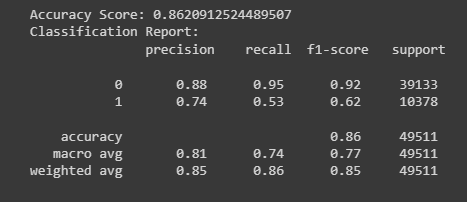

In [ ]:
rf_classifier.score(X_test, y_test)
# Score :  0.8620912524489507

0.8620912524489507

In [ ]:


rf_params = {
           "min_samples_split" : [2,5,10],
           "max_features" : [3,5],
           "n_estimators" : [200,500]
             }

rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(rf_classifier, rf_params, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)
print("En iyi doğruluk skoru:", grid_search.best_score_)

En iyi parametreler: {'max_features': 3, 'min_samples_split': 10, 'n_estimators': 500}
En iyi doğruluk skoru: 0.8627459512448752


<!-- En iyi parametreler: {'max_features': 3, 'min_samples_split': 10, 'n_estimators': 500}
En iyi doğruluk skoru: 0.8627459512448752 -->

En iyi parametreler: {'max_features': 3, 'min_samples_split': 10, 'n_estimators': 500}

En iyi doğruluk skoru: 0.8627459512448752

In [ ]:
rf_final = RandomForestClassifier(max_features= 3, min_samples_split= 10, n_estimators= 500, random_state=42, n_jobs=-1, verbose=True).fit(X,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.4min finished


In [ ]:
rf_final.score(X_test, y_test)
# 0.94015471309406  after hyper parametre optimization

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    4.9s finished


0.94015471309406

In [ ]:
cv_results = cross_validate(rf_final, X, y, cv=3,
                            scoring=["accuracy", "f1", "roc_auc"])

for i in cv_results:
  print(i, cv_results[i].mean())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    6.5s finis

fit_time 85.92059993743896
score_time 12.325533469518026
test_accuracy 0.863700804564315
test_f1 0.6237423945604356
test_roc_auc 0.8843198320403575


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    6.6s finished


# Feature Engeneering

In [ ]:
bins = [18, 25, 35, 45, 55, float('inf')]
labels = ['Young', 'Adult', 'Middle-aged', 'Older Adult', 'Senior']
df_train['AgeGroup'] = pd.cut(df_train['Age'], bins=bins, labels=labels, right=False)

In [ ]:
df_train.tail(20)

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,AgeGroup,AgeGroup_Ord
165014,165014,676,29.000,4,139825.340,2,1.000,1.000,116672.020,0,2.000,1,0,Adult,1.000
165015,165015,586,48.000,5,118022.740,1,0.000,0.000,180593.110,0,0.000,2,0,Older Adult,3.000
165016,165016,461,24.000,3,117412.340,1,1.000,0.000,177784.200,0,0.000,0,1,Young,0.000
165017,165017,598,40.000,2,0.000,2,1.000,0.000,187840.510,0,0.000,0,1,Middle-aged,2.000
165018,165018,644,43.000,2,0.000,2,1.000,1.000,50881.510,0,1.000,0,1,Middle-aged,2.000
165019,165019,719,32.000,6,134937.100,1,0.000,1.000,77500.480,0,2.000,0,0,Adult,1.000
165020,165020,679,32.000,8,145974.790,1,1.000,0.000,138875.860,0,2.000,0,1,Adult,1.000
165021,165021,632,41.000,6,0.000,2,0.000,1.000,128528.830,0,1.000,2,0,Middle-aged,2.000
165022,165022,577,45.000,2,0.000,1,0.000,0.000,148811.140,1,0.000,0,0,Older Adult,3.000
165023,165023,789,50.000,9,0.000,2,1.000,1.000,31840.590,0,4.000,2,1,Older Adult,3.000


In [ ]:

ordinal_encoder = OrdinalEncoder(categories=[['Young', 'Adult', 'Middle-aged', 'Older Adult', 'Senior']])
df_train['AgeGroup_Ord'] = ordinal_encoder.fit_transform(df_train[['AgeGroup']])
df_train.drop("AgeGroup", axis=1, inplace=True)

In [ ]:
df_train.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded,AgeGroup_Ord,CreditToBalanceRatio
id,,,,,,,,,,,,,,,,
0,0.437,0.636,0.203,0.300,0.000,2,1.000,0.000,0.907,0,2.000,0,1,0.688,1.000,0.786
1,0.734,0.554,0.203,0.100,0.000,2,1.000,1.000,0.247,0,1.000,0,1,0.688,1.000,0.738
2,0.515,0.656,0.297,1.000,0.000,2,1.000,0.000,0.924,0,2.000,0,1,0.421,2.000,0.798
3,0.703,0.462,0.216,0.200,0.593,1,1.000,1.000,0.423,0,0.000,0,1,0.465,1.000,0.000
4,0.802,0.732,0.203,0.500,0.000,2,1.000,1.000,0.075,0,2.000,2,1,0.167,1.000,0.842


In [ ]:
df_train['CreditToBalanceRatio'] = df_train['CreditScore'] / (df_train['Balance'] + 1)  # 1 eklenmesi sıfıra bölünme hatasını önler


In [ ]:
scaler = MinMaxScaler()


In [ ]:
df_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded,AgeGroup_Ord,CreditToBalanceRatio
id,,,,,,,,,,,,,,,
0,668,33.000,3,0.000,2,1.000,0.000,181449.970,0,2.000,0,1,1924,1.000,668.000
1,627,33.000,1,0.000,2,1.000,1.000,49503.500,0,1.000,0,1,1925,1.000,627.000
2,678,40.000,10,0.000,2,1.000,0.000,184866.690,0,2.000,0,1,1178,2.000,678.000
3,581,34.000,2,148882.540,1,1.000,1.000,84560.880,0,0.000,0,1,1299,1.000,0.004
4,716,33.000,5,0.000,2,1.000,1.000,15068.830,0,2.000,2,1,467,1.000,716.000


# Random Forest Model

In [ ]:
X, y = df_train.drop('Exited', axis=1), df_train['Exited']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1,bootstrap=True, criterion="entropy", max_features=0.5, min_samples_leaf=20, min_samples_split=15, n_estimators=100).fit(X,y)

In [ ]:
y_pred = rf_classifier.predict(X_test)

In [ ]:
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42, scoring='accuracy', cv=4, n_jobs=-1)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8649965720449402

Generation 2 - Current best internal CV score: 0.8649965720449402

Generation 3 - Current best internal CV score: 0.8649965720449402

Generation 4 - Current best internal CV score: 0.8649965720449402

Generation 5 - Current best internal CV score: 0.8649965720449402

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.55, min_samples_leaf=17, min_samples_split=20, n_estimators=100)


TPOTClassifier(cv=4, generations=5, n_jobs=-1, population_size=20,
               random_state=42, scoring='accuracy', verbosity=2)

In [ ]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.8837834016683161
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     39133
           1       0.80      0.60      0.68     10378

    accuracy                           0.88     49511
   macro avg       0.85      0.78      0.81     49511
weighted avg       0.88      0.88      0.88     49511



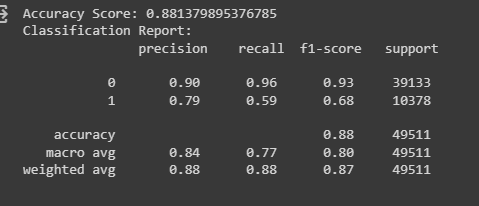

In [ ]:
X, y = df_train.drop('Exited', axis=1), df_train['Exited']

In [ ]:
tpot = TPOTClassifier(verbosity=2, generations=6, population_size=40, random_state=42, scoring='accuracy', cv=3, n_jobs=-1)
tpot.fit(X_train, y_train)


* Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.5, min_samples_leaf=20, min_samples_split=15, n_estimators=100)
* Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.55, min_samples_leaf=17, min_samples_split=20, n_estimators=100)

In [ ]:
lgb = LGBMClassifier(num_leaves=20, learning_rate=0.1, n_estimators=170, max_depth=7, min_child_samples=10, subsample=0.6).fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 24543, number of negative: 90980
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 115523, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212451 -> initscore=-1.310213
[LightGBM] [Info] Start training from score -1.310213


In [ ]:
lgb.score(X_test, y_test)

0.8674839934559997

In [ ]:
tpot.export('randomforest_tpot.py')

In [ ]:
%load randomforest_tpot.py

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  """
  *******
  Parametreler
  ------
    dataframe : dataframe
       Değişken isimleri alınmak istenen DataFrame'dir.

    cat_th :  int / float
        Numerik fakat kategorik olan değişkenler için sınıf eşiği

    car_th : int / float
      Kategorik fakat kardinal olan değişkenler için sınıf eşiği


  Returns
   ------
    cath_cols : list
         Kategorik değişken listesi
    num_cols : list
        Numerik değişken listesi
    cat_but_car :
        Kategorik gözüken fakat kardinal olan değişken listesi


  Notes :
  -----
    cath_cols + num_cols + cat_but_car = Toplam Değişken Sayısı
    -----------
    """
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if
                 dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]


  print(f"Obervations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f"cat_cols: {len(cat_cols)}")
  print(f"num_cols: {len(num_cols)}")
  print(f"cat_but_car: {len(cat_but_car)}")
  print(f"num_but_cat: {len(num_but_cat)}")

  return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Obervations: 165034
Variables: 15
cat_cols: 8
num_cols: 7
cat_but_car: 0
num_but_cat: 8


In [ ]:
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

In [ ]:
df_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded,AgeGroup_Ord,CreditToBalanceRatio
id,,,,,,,,,,,,,,,
0,0.636,0.203,0.300,0.000,2,1.000,0.000,0.907,0,2.000,0,1,0.688,1.000,0.786
1,0.554,0.203,0.100,0.000,2,1.000,1.000,0.247,0,1.000,0,1,0.688,1.000,0.738
2,0.656,0.297,1.000,0.000,2,1.000,0.000,0.924,0,2.000,0,1,0.421,2.000,0.798
3,0.462,0.216,0.200,0.593,1,1.000,1.000,0.423,0,0.000,0,1,0.465,1.000,0.000
4,0.732,0.203,0.500,0.000,2,1.000,1.000,0.075,0,2.000,2,1,0.167,1.000,0.842


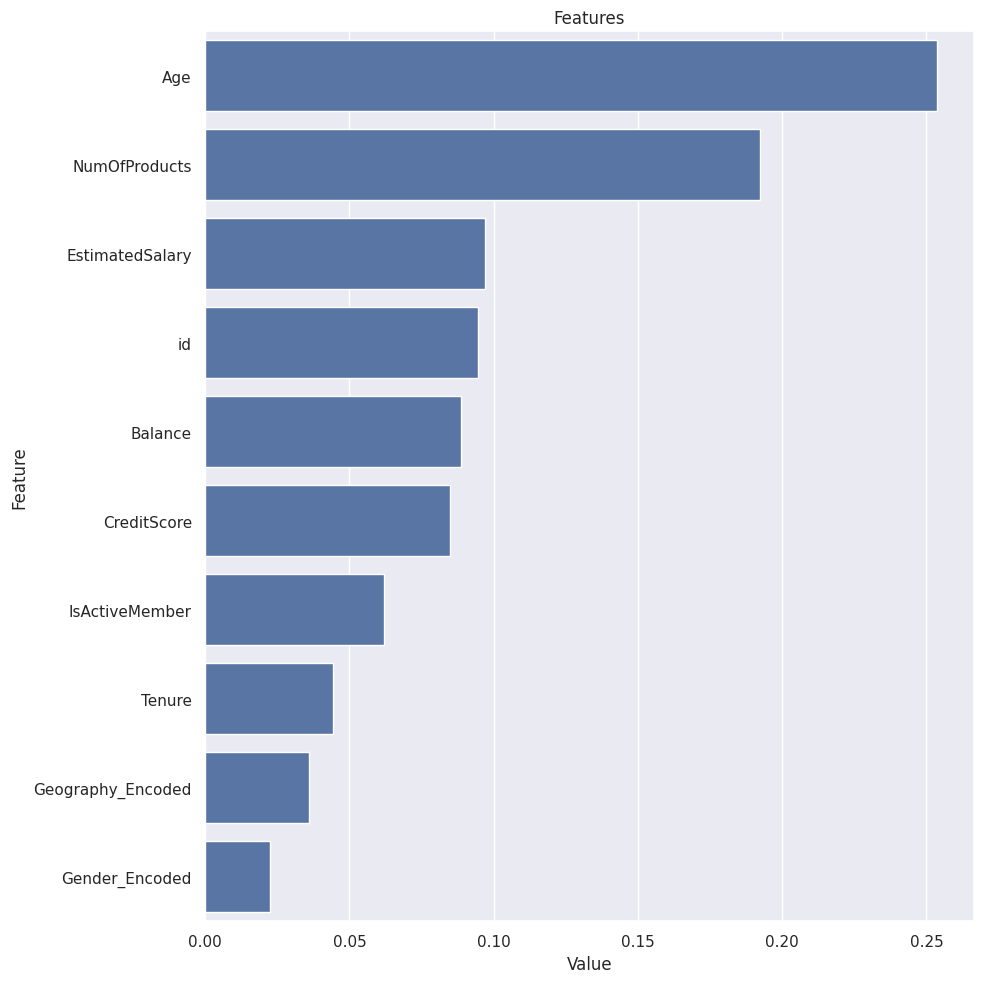

In [ ]:
plot_importance(rf_final, X, 10)

In [ ]:
catboost_model.score(X_test, y_test)

0.8652016723556382

In [ ]:
final_model.predict(X_test)

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
final_model.score(X_test, y_test)

# 0.8647169315909596

0.8647169315909596

* İlerleme : Catboost ve scale ile birlikte final model başarısı 0.8647'ye yükseldi.
* ilerleme 2 : Catboost, scale ve feature extraction ile 0.8652 yükseldi.  
* İlerleme 3 : Random Forest ile tpot parametreleri kullanılarak model başarısı 0.88'e yükseldi.

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
  """
model = Kullandığımız model Decision Trees, Random Forests, Gradient Boosting Machines (GBM), XGBoost, Light GBM gibi modeller olabilir.
features = Değişkenler
num = Kaç değişken göstermek istiyoruz









  """
  feature_imp = pd.DataFrame({"Value" : model.feature_importances_, "Feature" : features.columns })
  plt.figure(figsize= (10,10))
  sns.set(font_scale=1)
  sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])

  plt.title("Features")
  plt.tight_layout()
  plt.show()
  if save:
    plt.savefig("importances.png")


# Test Prediction Prep

In [ ]:
def data_prep(df):
  df = df.drop(columns=["CustomerId"])
  bins = [300, 600, 660, 720, 780, 851]
  labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']

  df['CreditScore_Col'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)

  ordinal_encoder = OrdinalEncoder(categories=[['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']])
  df['CreditScore_Col_Ord'] = ordinal_encoder.fit_transform(df[['CreditScore_Col']])

  le=LabelEncoder()
  df["Geography_Encoded"] = le.fit_transform(df["Geography"])
  # France : 0 , Germany = 1, Spain : 2

  df["Gender_Encoded"] = le.fit_transform(df["Gender"])

  # Female : 0, Male : 1

  df["Gender_Encoded"] = le.fit_transform(df["Gender"])


  # Female : 0, Male : 1


  df["Surname_Encoded"] = le.fit_transform(df["Surname"])

  df.drop(["Gender","Geography", "Surname", "CreditScore_Col"], axis=1, inplace=True)

  bins = [18, 25, 35, 45, 55, float('inf')]
  labels = ['Young', 'Adult', 'Middle-aged', 'Older Adult', 'Senior']
  df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


  ordinal_encoder = OrdinalEncoder(categories=[['Young', 'Adult', 'Middle-aged', 'Older Adult', 'Senior']])
  df['AgeGroup_Ord'] = ordinal_encoder.fit_transform(df[['AgeGroup']])
  df.drop("AgeGroup", axis=1, inplace=True)

  df['CreditToBalanceRatio'] = df['CreditScore'] / (df['Balance'] + 1)  # 1 eklenmesi sıfıra bölünme hatasını önler

  scaler = MinMaxScaler()

  cat_cols, num_cols, cat_but_car = grab_col_names(df)

  df[num_cols] = scaler.fit_transform(df[num_cols])

  return df



In [ ]:
df_test = data_prep(df_test)

Obervations: 110023
Variables: 14
cat_cols: 7
num_cols: 7
cat_but_car: 0
num_but_cat: 7


In [ ]:
df_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded,AgeGroup_Ord,CreditToBalanceRatio
id,,,,,,,,,,,,,,
165034,0.472,0.068,0.200,0.000,2,0.000,1.000,0.805,0.000,0,0,0.547,0.000,0.689
165035,0.666,0.378,0.200,0.000,1,1.000,0.000,0.363,2.000,0,0,0.669,3.000,0.804
165036,0.612,0.216,0.700,0.000,2,1.000,0.000,0.694,1.000,0,0,0.460,1.000,0.772
165037,0.662,0.243,0.800,0.000,1,1.000,0.000,0.570,2.000,0,1,0.677,2.000,0.801
165038,0.804,0.270,1.000,0.483,1,1.000,0.000,0.697,3.000,1,1,0.399,2.000,0.000


In [ ]:
y_test_pred = rf_classifier.predict_proba(df_test)[:, 1]

In [ ]:
y_test_pred_extra = exported_pipeline.predict_proba(df_test)[:, 1]

In [ ]:
df_test['Exited'] = y_test_pred_extra

In [ ]:
df_test = df_test.reset_index()


In [ ]:
df_test.head()

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,CreditScore_Col_Ord,Geography_Encoded,Gender_Encoded,Surname_Encoded,AgeGroup_Ord,CreditToBalanceRatio,Exited
0,165034,0.472,0.068,0.200,0.000,2,0.000,1.000,0.805,0.000,0,0,0.547,0.000,0.689,0.030
1,165035,0.666,0.378,0.200,0.000,1,1.000,0.000,0.363,2.000,0,0,0.669,3.000,0.804,0.866
2,165036,0.612,0.216,0.700,0.000,2,1.000,0.000,0.694,1.000,0,0,0.460,1.000,0.772,0.014
3,165037,0.662,0.243,0.800,0.000,1,1.000,0.000,0.570,2.000,0,1,0.677,2.000,0.801,0.249
4,165038,0.804,0.270,1.000,0.483,1,1.000,0.000,0.697,3.000,1,1,0.399,2.000,0.000,0.334


In [ ]:

df_results = df_test[['id', 'Exited']]
df_results.to_csv('submission.csv', index=False)

In [ ]:
df_results.head()

,id,Exited
0,165034,0.014
1,165035,0.918
2,165036,0.008
3,165037,0.207
4,165038,0.322
